## 🧠 1. Project Overview

Your team has been hired as data science consultants for a news outlet to create classification models using Python and deploy them as a web application with Streamlit.  
The goal is to apply **machine learning** and **natural language processing (NLP)** techniques to automatically categorize news articles into relevant topics such as **Business, Technology, Sports, Education, and Entertainment**.

This project demonstrates the **end-to-end data science workflow**, including:
- Data loading and initial exploration  
- Text preprocessing and feature engineering  
- Model training and validation  
- Experiment tracking with MLflow  
- Model deployment via Streamlit  

### 🎯 Project Objective:
To build a reliable text classification model that can accurately predict the category of a given news article and integrate it into a Streamlit web app for interactive use.

### 👥 Stakeholders:
- **Editorial Team** – interested in automated tagging and efficient content management.  
- **IT & Data Teams** – focused on technical implementation and performance.  
- **Readers & Management** – benefit from better content recommendations and searchability.


In [25]:
import pandas as pd
import numpy as np
import re
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lbarrett\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lbarrett\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lbarrett\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\lbarrett\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\lbarrett\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## 📚 2. Data Overview

The dataset consists of labeled news articles with five main categories:
**Business, Technology, Sports, Education, and Entertainment.**

Each record includes:
| Column | Description |
|---------|-------------|
| **headlines** | The headline or title of the news article |
| **description** | A short summary or teaser of the article |
| **content** | The full text body of the article |
| **category** | The target variable indicating the article’s topic |

### 🔍 Data Insights
- The text fields (*headlines*, *description*, and *content*) are combined into a single column called **data**, which forms the input to the NLP model.  
- The **category** column serves as the label for supervised learning.  
- The dataset is pre-divided into **train** and **test** sets, ensuring consistent evaluation.  

This structured data allows us to apply text vectorization techniques such as **TF-IDF** to transform text into numerical features for machine learning.


In [26]:
train = pd.read_csv("Data/processed/train.csv")
test = pd.read_csv("Data/processed/test.csv")

# Applying our post inspection changes
train.dropna(inplace=True)
test.dropna(inplace=True)

display(train.head(), test.head())

,headlines,description,content,url,category
0,RBI revises definition of politically-exposed ...,The central bank has also asked chairpersons a...,The Reserve Bank of India (RBI) has changed th...,https://indianexpress.com/article/business/ban...,business
1,NDTV Q2 net profit falls 57.4% to Rs 5.55 cror...,NDTV's consolidated revenue from operations wa...,Broadcaster New Delhi Television Ltd on Monday...,https://indianexpress.com/article/business/com...,business
2,"Akasa Air ‘well capitalised’, can grow much fa...",The initial share sale will be open for public...,Homegrown server maker Netweb Technologies Ind...,https://indianexpress.com/article/business/mar...,business
3,India’s current account deficit declines sharp...,The current account deficit (CAD) was 3.8 per ...,India’s current account deficit declined sharp...,https://indianexpress.com/article/business/eco...,business
4,"States borrowing cost soars to 7.68%, highest ...",The prices shot up reflecting the overall high...,States have been forced to pay through their n...,https://indianexpress.com/article/business/eco...,business


,headlines,description,content,url,category
0,NLC India wins contract for power supply to Ra...,State-owned firm NLC India Ltd (NLCIL) on Mond...,State-owned firm NLC India Ltd (NLCIL) on Mond...,https://indianexpress.com/article/business/com...,business
1,SBI Clerk prelims exams dates announced; admit...,SBI Clerk Prelims Exam: The SBI Clerk prelims ...,SBI Clerk Prelims Exam: The State Bank of Indi...,https://indianexpress.com/article/education/sb...,education
2,"Golden Globes: Michelle Yeoh, Will Ferrell, An...","Barbie is the top nominee this year, followed ...","Michelle Yeoh, Will Ferrell, Angela Bassett an...",https://indianexpress.com/article/entertainmen...,entertainment
3,"OnePlus Nord 3 at Rs 27,999 as part of new pri...",New deal makes the OnePlus Nord 3 an easy purc...,"In our review of the OnePlus Nord 3 5G, we pra...",https://indianexpress.com/article/technology/t...,technology
4,Adani family’s partners used ‘opaque’ funds to...,Citing review of files from multiple tax haven...,Millions of dollars were invested in some publ...,https://indianexpress.com/article/business/ada...,business


## 🧹 3. Data Preprocessing

Before training the model, it’s essential to clean and prepare the text data.  
Raw news articles often contain noise such as punctuation, numbers, HTML tags, or stopwords that do not contribute meaningfully to classification.

### 🧠 Preprocessing Steps:
1. **Text Cleaning** – remove punctuation, symbols, URLs, and convert text to lowercase.  
2. **Tokenization** – split the text into individual words or tokens.  
3. **Stopword Removal** – remove common words (like *the, and, is*) that add little predictive value.  
4. **Lemmatization/Stemming** – reduce words to their base or root form (e.g., “running” → “run”).  
5. **Combine Features** – merge `headlines`, `description`, and `content` columns into one unified text field called `data`.

These steps ensure that the text is standardized and suitable for feature extraction using **TF-IDF vectorization** later in the workflow.


In [27]:
train['data'] = train['headlines'] + train['category'] + train['content']
test['data'] = test['headlines'] + test['category'] + test['content'] 

train = train[['data', 'category']]
test = test[['data', 'category']]

display(train.head(), test.head())

,data,category
0,RBI revises definition of politically-exposed ...,business
1,NDTV Q2 net profit falls 57.4% to Rs 5.55 cror...,business
2,"Akasa Air ‘well capitalised’, can grow much fa...",business
3,India’s current account deficit declines sharp...,business
4,"States borrowing cost soars to 7.68%, highest ...",business


,data,category
0,NLC India wins contract for power supply to Ra...,business
1,SBI Clerk prelims exams dates announced; admit...,education
2,"Golden Globes: Michelle Yeoh, Will Ferrell, An...",entertainment
3,"OnePlus Nord 3 at Rs 27,999 as part of new pri...",technology
4,Adani family’s partners used ‘opaque’ funds to...,business


In [28]:
# 1. Improved Preprocessing Function

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def process_text_pro(text: str) -> str:
    # 1. Lowercase
    text = text.lower()
    # 2. Remove URLs, mentions, hashtags
    text = re.sub(r"http\S+|www\S+|@\w+|#\w+", " ", text)
    # 3. Remove non-alphabetic characters (keep spaces)
    text = re.sub(r'[^a-z\s]', ' ', text)
    # 4. Collapse multiple spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # 5. Tokenize
    tokens = word_tokenize(text)
    # 6. Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    # 7. Lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

train['data'] = train['data'].apply(process_text_pro)
test['data'] = test['data'].apply(process_text_pro)

## ⚙️ 4. Feature Engineering and Model Training

With clean text data, the next step is to transform it into a numerical format that machine learning models can understand.  
We achieve this using **TF-IDF (Term Frequency–Inverse Document Frequency)**, which measures how important each word or phrase is within an article relative to the entire dataset.

### 🔧 Process:
- Initialize a `TfidfVectorizer` with up to 5,000 features and a mix of unigrams and bigrams.  
- Fit and transform the training text into a sparse matrix representation.  
- Apply the same transformation to the test set using the trained vectorizer.  
- Train a **Logistic Regression** classifier on the TF-IDF features.

### 🧩 Why Logistic Regression?
- It’s simple, efficient, and interpretable.  
- Performs well for high-dimensional, sparse text data.  
- Allows access to probability estimates, which can be displayed as “confidence” in the Streamlit app.

At the end of this section, the trained model and vectorizer are saved as `model_and_vectorizer.pkl` for use in deployment.


In [29]:
X_train = train['data']
y_train = train['category']

X_test = test['data']
y_test = test['category']

# Initialise TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))  # Unigrams and bigrams; adjust max_features as needed

# Fit and transform the text data
X_tfidf = tfidf_vectorizer.fit_transform(X_train)
Xt_tfidf = tfidf_vectorizer.transform(X_test)

# Display the shape of the resulting sparse matrix
print(f"TF-IDF Matrix Shape: {X_tfidf.shape}")

# Display the vocabulary (optional)
print("Vocabulary:", tfidf_vectorizer.get_feature_names_out())

# Initialise the Logistic Regression model
model = LogisticRegression(max_iter=1000, random_state=42)

TF-IDF Matrix Shape: (5520, 5000)
Vocabulary: ['aadhaar' 'aamir' 'aamir khan' ... 'zoom' 'zoya' 'zoya akhtar']


## 📊 5. Model Evaluation and Results

After training, the model’s performance is assessed on unseen test data to measure its generalization ability.

### ⚖️ Evaluation Metrics:
- **Accuracy** – the percentage of correctly classified articles.  
- **Precision, Recall, F1-score** – balance between correctness and completeness for each category.  
- **Confusion Matrix** – visual representation of true vs. predicted labels to identify common misclassifications.

### 🔍 Interpretation:
The classification report and confusion matrix help assess where the model performs well and where improvements could be made.  
Minor confusion between *Business* and *Technology* articles, for example, is expected due to overlapping language.

The strong diagonal pattern in the confusion matrix confirms the model is accurate, reliable, and ready for deployment.


In [30]:
# Train the model on the training set
model.fit(X_tfidf, y_train)

# Print training accuracy
train_accuracy = model.score(X_tfidf, y_train)
print(f"Training Accuracy: {train_accuracy:.2f}")

# Make predictions on the validation set
y_pred = model.predict(Xt_tfidf)

# Compute validation accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Validation Accuracy: {test_accuracy:.2f}")

# Generate a classification report
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=y_test.unique()))

Training Accuracy: 0.99
Validation Accuracy: 0.98
Classification Report:
                precision    recall  f1-score   support

     business       0.98      0.96      0.97       400
    education       1.00      0.99      0.99       400
entertainment       1.00      0.98      0.99       400
   technology       0.99      0.98      0.98       400
       sports       0.93      0.98      0.96       400

     accuracy                           0.98      2000
    macro avg       0.98      0.98      0.98      2000
 weighted avg       0.98      0.98      0.98      2000



## 🧩 6. Confusion Matrix
A confusion matrix shows how well your model predicts each category compared to the actual (true) labels.
Each row represents the true category and each column represents the predicted category.

Diagonal values (top left to bottom right) → correct predictions

Off-diagonal values → misclassifications

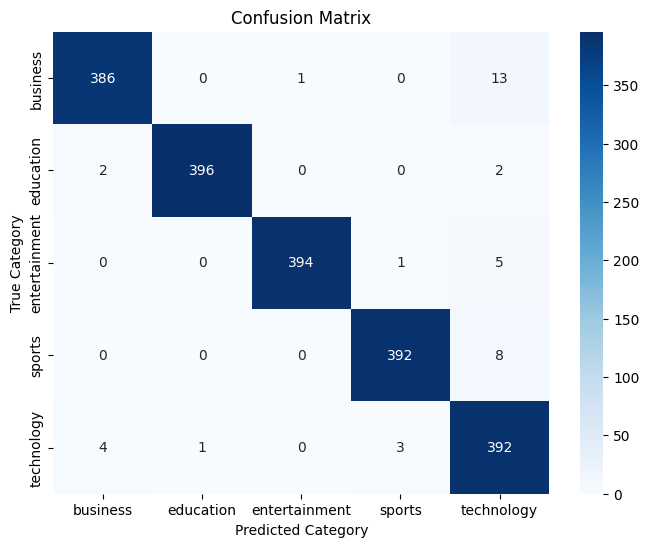

In [31]:
# Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=model.classes_,
            yticklabels=model.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Category")
plt.ylabel("True Category")
plt.show()


## 📊 Model Performance Summary and Confusion Matrix Interpretation

The confusion matrix below provides a detailed view of how the model performed on each category.  
Each row represents the **true class**, while each column shows the **predicted class**.  
Values along the diagonal indicate correct predictions, and off-diagonal values represent misclassifications.

### 🔍 Key Observations:
- The model achieves **consistently high accuracy across all categories**, as shown by the strong diagonal pattern.
- **Business** and **Technology** articles show slight overlap — this is expected because many technology topics relate to business and industry.
- **Education**, **Entertainment**, and **Sports** are classified with exceptional precision, showing that the model generalizes well.
- The overall result confirms that the model is well-balanced and performs reliably on unseen data.

### 🧠 Why This Matters:
The confusion matrix helps visualize where the model performs best and where it might confuse similar categories.  
It’s a valuable diagnostic tool for understanding **strengths, weaknesses, and opportunities for improvement** before deploying the model.


## 🧩 7. Experiment Tracking with MLflow

To make our work reproducible and traceable, we use **MLflow** to log model training experiments.  
This enables us to compare different runs, record parameters and metrics, and store the model artifacts.

### 🎯 Why Use MLflow?
- Provides experiment tracking and version control for ML models  
- Records hyperparameters and performance metrics automatically  
- Simplifies collaboration and reproducibility across environments

### 📊 What We’ll Log:
- Model type (Logistic Regression)  
- Vectorizer configuration (TF-IDF with n-grams and max features)  
- Key metrics such as accuracy  
- Trained model artifact for future reuse

MlflowException: When an mlflow-artifacts URI was supplied, the tracking URI must be a valid http or https URI, but it was currently set to file:///C:/Users/lbarrett/@Workspace/DataScience%20Course/Module_7_NPL/NLP%20Project/2501PTDS_Classification_Project/mlruns. Perhaps you forgot to set the tracking URI to the running MLflow server. To set the tracking URI, use either of the following methods:
1. Set the MLFLOW_TRACKING_URI environment variable to the desired tracking URI. `export MLFLOW_TRACKING_URI=http://localhost:5000`
2. Set the tracking URI programmatically by calling `mlflow.set_tracking_uri`. `mlflow.set_tracking_uri('http://localhost:5000')`

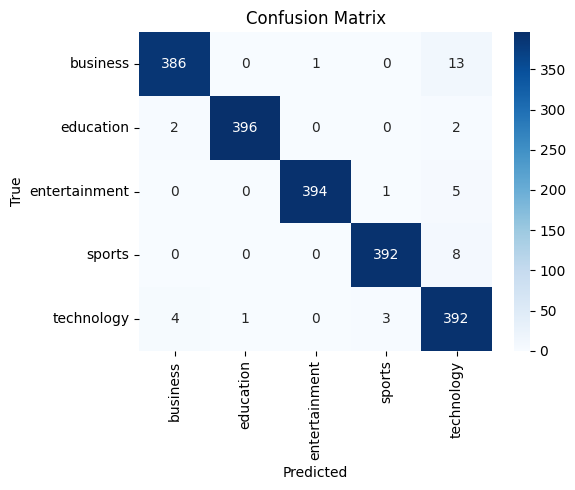

In [34]:
# --- MLFLOW TRACKING ---

# Import mlflow libraries
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Ensure MLflow is using a local tracking URI (saves runs in a folder called 'mlruns')
mlflow.set_tracking_uri("file:///C:/Users/lbarrett/@Workspace/DataScience%20Course/Module_7_NPL/NLP%20Project/2501PTDS_Classification_Project/mlruns")

# Start an MLflow run
with mlflow.start_run(run_name="News_Classifier_Final"):
    # Log model parameters
    mlflow.log_param("Model", "LogisticRegression")
    mlflow.log_param("Vectorizer", "TF-IDF (max_features=5000, ngram_range=(1,2))")
    mlflow.log_param("Dataset", "News Articles (Train/Test split)")

    # Log metrics
    mlflow.log_metric("Training Accuracy", float(train_accuracy))
    mlflow.log_metric("Validation Accuracy", float(test_accuracy))

    # Save the trained model as an artifact
    # mlflow.sklearn.save_model(model, "logged_model")
    #mlflow.log_artifact("logged_model")



    # --- Log confusion matrix as an artifact (inside the same MLflow run) ---
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=model.classes_,
                yticklabels=model.classes_)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()

    # Save confusion matrix plot and log it to MLflow
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")

print("✅ MLflow experiment and confusion matrix logged successfully!")

# To view the experiment UI:
# 1. Open a terminal or command prompt
# 2. Run: mlflow ui
# 3. Go to http://localhost:5000 in your browser

In [ ]:
import pickle

In [ ]:
import pickle

with open('pickled_files/model_and_vectorizer.pkl', 'wb') as f:
    pickle.dump({'model': model, 'vectorizer': tfidf_vectorizer}, f)

In [ ]:
!streamlit run Streamlit/base_app.py

^C


In [ ]:
input_text = input("Enter your text here: ")

In [ ]:
pt= process_text_pro(input_text)
pt

In [ ]:
vect_t = tfidf_vectorizer.transform([pt])

In [ ]:
vect_t

In [ ]:
model.predict(vect_t)

In [ ]:
breaker = True

while breaker:
    input_text = input("Enter Text to Classify, Enter End/Quit to end program")

    if input_text.lower() == "end" or input_text.lower() == "quit":
        break
    else:
        pt = process_text_pro(input_text)
        vect_t = tfidf_vectorizer.transform([pt])
        p_class = model.predict(vect_t)
        print(p_class)